In [2]:
import torch
import cv2
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

from model import BiSeNet
from utils import load_model

device = 'cuda' if torch.cuda.is_available() else 'cpu'

checkpoint_path = '/opt/ml/input/virtual-background/model_weights/checkpoint-epoch9.pth'
test_img_path = '/opt/ml/input/virtual-background/data/the-rock.jpeg'
test_background_path = '/opt/ml/input/virtual-background/data/alphaca.jpeg'

In [3]:
def prepare_model(checkpoint_path):
    model = BiSeNet(num_classes=1, training=False)
    model = model.to(device)
    load_model(model, checkpoint_path)
    model.eval()
    return model

In [4]:
def resize_img(img, h=512, w=512):
    img = A.Resize(512, 512)(image=img)['image']
    return img

In [5]:
def inference_single_img(model, img_np_array):
    transform = A.Compose([
                    A.Resize(512, 512),
                    A.Normalize(
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                    ),
                    ToTensorV2()
                ])
    
    img = transform(image=img_np_array)['image'].to(device)
    img = img.unsqueeze(dim=0)
    mask = model(img).squeeze()
    mask = torch.sigmoid(mask).detach().cpu().numpy()
    mask = (mask > 0.5) * 1
    return mask

Text(0.5, 1.0, 'Masked Image')

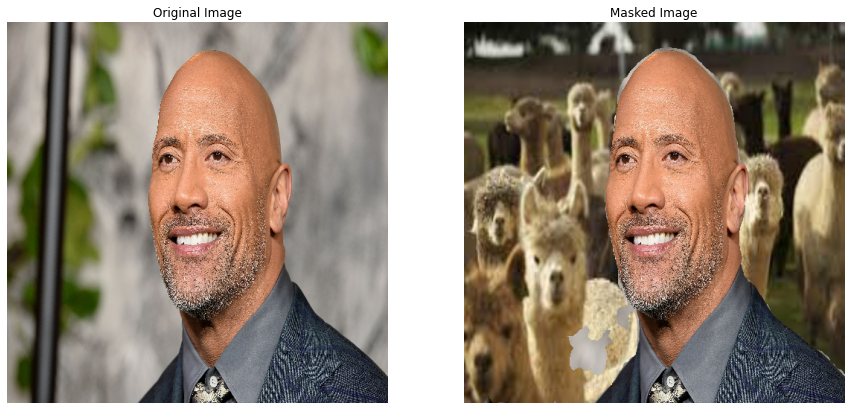

In [6]:
model = prepare_model(checkpoint_path)

img = cv2.imread(test_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
org_img = img.copy()

background = cv2.imread(test_background_path)
background = cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
background = resize_img(background)

mask = inference_single_img(model, img)
mask = np.expand_dims(mask, axis=0)
mask = np.vstack((mask, mask, mask)).transpose((1, 2, 0))
img = resize_img(img)
masked_img = np.where(mask == 0, background, img)

fig = plt.figure(figsize=(15, 15))

fig.add_subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')

fig.add_subplot(1, 2, 2)
plt.imshow(masked_img)
plt.axis('off')
plt.title("Masked Image")